[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/movielens_skorch.ipynb)

# Genre prediction model
Goal is to use ratings data to predict genres of items

**Step 1:**
Train a base model to predict user ratings

![ratings-model](https://github.com/James-Leslie/deep-collaborative-filtering/blob/master/figures/ratings-model.pdf)

**Step 2:**

![genre-model](https://github.com/James-Leslie/deep-collaborative-filtering/blob/master/figures/genre-model.pdf)

In [ ]:
!pip install tensorflow-gpu==2.0.0-beta1

In [1]:
%load_ext tensorboard

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, datetime
from urllib.request import urlopen
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split

%matplotlib inline

## Load ratings data

In [3]:
path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/goodbooks-10k/'  # access from anywhere
# path = 'data/ml-10M100K/'  # if the files are local
train = df = pd.concat((pd.read_csv(path+'train1.csv'), pd.read_csv(path+'train2.csv')), ignore_index=True)
test = pd.read_csv(path+'test.csv')
df = pd.concat((train, test), ignore_index=True)

In [4]:
df.head()

,userId,movieId,rating
0,17186,12,3.0
1,4960,5764,4.0
2,52144,1616,4.0
3,68149,1466,3.5
4,16898,1124,2.0


In [5]:
df.shape

(10000054, 3)

In [6]:
n_users = df.userId.max() + 1
n_items = df.movieId.max() + 1
min_rating = df.rating.min()
max_rating = df.rating.max()

## Ratings model

In [7]:
from tensorflow.keras import backend as K

def stretch(x):
    return K.sigmoid(x) * (max_rating - min_rating) + min_rating

In [8]:
# item embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(n_items, 25, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users, 25, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([item_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(64, activation='relu')(conc)
d1 = Dropout(.5)(fc1)
fc2 = Dense(32, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
out = Dense(1, activation=stretch)(d2)

# create model and compile it
model = Model([user_input, item_input], out)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 25)        266925      Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 25)        1746950     User-Input[0][0]                 
______________________________________________________________________________________________

#### load pre-trained weights

In [ ]:
# ONLY RUN THIS BLOCK IF USING COLAB
# os.makedirs('models', exist_ok=True)

# # stable link for dataset
# url = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/models/'
# checkpoints = ['movielens10M.ckpt.index', 'movielens10M.ckpt.data-00000-of-00002', 'movielens10M.ckpt.data-00001-of-00002']

# for c in checkpoints:
#     downloaded = urlopen(url + c)
#     buf = downloaded.read()

#     # save file and extract contents
#     with open('models/'+c, 'wb') as f:
#         f.write(buf)

In [9]:
model.load_weights("models/movielens10M.ckpt")

#### check its predictive accuracy on the ratings

In [10]:
model.evaluate([df.userId, df.movieId], df.rating, batch_size=1024)

10000054/10000054 [==============================] - 63s 6us/sample - loss: 0.6412


0.6411908849552477

In [11]:
np.sqrt(0.6412)

0.8007496487667041

In [12]:
predictions = model.predict([df.userId.head(10), df.movieId.head(10)])

[print(predictions[i], df.rating.iloc[i]) for i in range(0,10)]

[3.4416304] 3.0
[3.6104715] 4.0
[3.5779662] 4.0
[3.340524] 3.5
[2.1260123] 2.0
[2.9319258] 3.0
[3.3849223] 3.5
[2.7936099] 2.5
[2.7770824] 3.0
[4.0854893] 4.0


[None, None, None, None, None, None, None, None, None, None]

## Create second model to predict genres
We will re-use the item embedding layer from the base model to learn a mapping between embeddings and genres

In [15]:
# checkpoint_path = "models/goodbooks_genres.ckpt"
# # checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create checkpoint callback
# cp_callback = ModelCheckpoint(checkpoint_path,
#                               save_weights_only=True,
#                               verbose=1)

In [13]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1, embeddings_freq=1)
os.makedirs(logdir, exist_ok=True)

In [18]:
# make new genre model
fc1 = Dense(32, activation='relu')(item_vec)
d1 = Dropout(.5)(fc1)
fc2 = Dense(24, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
genre_out = Dense(18, activation='sigmoid')(d2)

# Create model and compile it
model2 = Model(item_input, genre_out)
# freeze the embedding layer
model2.layers[1].trainable = False
model2.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Item-Input (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
Item-Embedding (Embedding)   (None, 1, 25)             266925    
_________________________________________________________________
Flatten-Items (Flatten)      (None, 25)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                832       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 24)                792       
_________________________________________________________________
dropout_5 (Dropout)          (None, 24)                0   

In [23]:
movies = pd.read_csv(path+'movies.tsv', sep='\t')

In [24]:
movies.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,Boomerang (1992),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,"Net, The (1995)",1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,2,Dumb & Dumber (1994),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,Outbreak (1995),1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
4,4,Stargate (1994),1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [25]:
movies.shape

(10677, 20)

In [26]:
history = model2.fit(movies.movieId, movies.iloc[:,-18:], 
                     batch_size=64, 
                     epochs=10,
                     validation_split=.2,
                     callbacks=[tensorboard_callback])

# plt.plot(history.history['loss'])
# plt.xlabel("Epochs")
# plt.ylabel("Training Error")

W0713 18:17:40.835523 14820 deprecation.py:323] From C:\Users\jlesl\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8541 samples, validate on 2136 samples
Epoch 1/10
8541/8541 [==============================] - 2s 219us/sample - loss: 0.5217 - accuracy: 0.7592 - val_loss: 0.3182 - val_accuracy: 0.9083
Epoch 2/10
8541/8541 [==============================] - 1s 139us/sample - loss: 0.3440 - accuracy: 0.8839 - val_loss: 0.2805 - val_accuracy: 0.9100
Epoch 3/10
8541/8541 [==============================] - 1s 134us/sample - loss: 0.3240 - accuracy: 0.8871 - val_loss: 0.2708 - val_accuracy: 0.9099
Epoch 4/10
8541/8541 [==============================] - 1s 134us/sample - loss: 0.3148 - accuracy: 0.8885 - val_loss: 0.2689 - val_accuracy: 0.9098
Epoch 5/10
8541/8541 [==============================] - 1s 136us/sample - loss: 0.3087 - accuracy: 0.8890 - val_loss: 0.2667 - val_accuracy: 0.9102
Epoch 6/10
8541/8541 [==============================] - 1s 123us/sample - loss: 0.3040 - accuracy: 0.8899 - val_loss: 0.2645 - val_accuracy: 0.9103
Epoch 7/10
8541/8541 [==============================] - 1s 128us

### Open tensorboard to look at the embeddings
  1. Run the block below
  2. Click on the "Projector" tab
  3. [Click here to download the embedding metadata file to your local machine](https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/goodbooks-10k/books.tsv)
  4. Look for a button labelled "Load" in the panel on the left, use this to load the embedding metadata

In [27]:
%tensorboard --logdir {logs}

Reusing TensorBoard on port 6006 (pid 11160), started 7:52:50 ago. (Use '!kill 11160' to kill it.)

In [28]:
model2.evaluate(movies.movieId, movies.iloc[:,-18:], batch_size=128)

10677/10677 [==============================] - 0s 28us/sample - loss: 0.2764 - accuracy: 0.8961


[0.2763676604768405, 0.8960643]

In [29]:
# check predictions of first 10 books
np.round(model2.predict(movies.movieId.head(10)))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)

## Check accuracy for only the Drama tag

In [32]:
movies.mean()

movieId        5338.000000
Action            0.137960
Adventure         0.096001
Animation         0.026787
Children          0.049452
Comedy            0.346820
Crime             0.104617
Documentary       0.045050
Drama             0.499766
Fantasy           0.050857
Film-Noir         0.013862
Horror            0.094877
Musical           0.040835
Mystery           0.047673
Romance           0.157816
Sci-Fi            0.070619
Thriller          0.159689
War               0.047766
Western           0.025756
dtype: float64

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [31]:
y_true = movies.iloc[:,-18:]
y_score = pd.DataFrame(model2.predict(movies.movieId), columns=y_true.columns)
y_pred = y_score.round().astype('int')

In [33]:
drama_true = y_true.Drama
drama_pred = y_pred.Drama

In [34]:
print(classification_report(drama_true, drama_pred))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63      5341
           1       0.63      0.68      0.65      5336

   micro avg       0.64      0.64      0.64     10677
   macro avg       0.64      0.64      0.64     10677
weighted avg       0.64      0.64      0.64     10677



In [35]:
pd.DataFrame(confusion_matrix(drama_true, drama_pred))

,0,1
0,3244,2097
1,1722,3614


In [36]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(drama_true, y_score.Drama)

In [37]:
prt_df = pd.DataFrame([thresholds, precision, recall]).T
prt_df.columns = ['threshold','precision','recall']
prt_df.head()

,threshold,precision,recall
0,0.067708,0.499906,1.000000
1,0.068340,0.499859,0.999813
2,0.073628,0.499906,0.999813
3,0.073643,0.499953,0.999813
4,0.073964,0.500000,0.999813


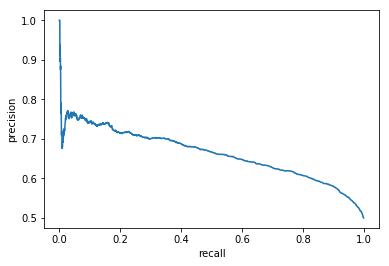

In [38]:
sns.lineplot(x=prt_df.recall,
             y=prt_df.precision)
plt.show()

### Global accuracy

In [39]:
(y_true == y_pred).astype('int').mean()

Action         0.862040
Adventure      0.903999
Animation      0.973213
Children       0.950548
Comedy         0.656458
Crime          0.895383
Documentary    0.954950
Drama          0.642315
Fantasy        0.949143
Film-Noir      0.986138
Horror         0.905123
Musical        0.959165
Mystery        0.952327
Romance        0.842184
Sci-Fi         0.929381
Thriller       0.840311
War            0.952234
Western        0.974244
dtype: float64

In [40]:
from sklearn.metrics import accuracy_score, coverage_error
# how many perfectly classified rows?
accuracy_score(y_true, y_pred)

0.13168493022384564

In [41]:
coverage_error(y_true, y_score)

5.891448908869533

In [42]:
print(classification_report(y_true, y_pred, target_names=y_true.columns))

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00      1473
   Adventure       0.00      0.00      0.00      1025
   Animation       0.00      0.00      0.00       286
    Children       0.00      0.00      0.00       528
      Comedy       0.54      0.06      0.11      3703
       Crime       0.00      0.00      0.00      1117
 Documentary       0.00      0.00      0.00       481
       Drama       0.63      0.68      0.65      5336
     Fantasy       0.00      0.00      0.00       543
   Film-Noir       0.00      0.00      0.00       148
      Horror       0.00      0.00      0.00      1013
     Musical       0.00      0.00      0.00       436
     Mystery       0.00      0.00      0.00       509
     Romance       0.00      0.00      0.00      1685
      Sci-Fi       0.00      0.00      0.00       754
    Thriller       0.00      0.00      0.00      1705
         War       0.00      0.00      0.00       510
     Western       0.00    

C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [43]:
(y_true == y_pred).astype('int').mean().mean()

0.8960642294443925

In [44]:
f1_score(y_true, y_pred, average='micro')

0.27807293360800894

### Precision and Recall

In [45]:
recall_score(y_true, y_pred, average='micro')

0.17870581130673108

In [46]:
precision_score(y_true, y_pred, average='micro')

0.6263432106805601